# 오차역전파법

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# 단순한 계층 구현하기

곱셈 계층 먼저 구현 

- 순전파 : 입력을 *

- 역전파 : 상류에서 넘어온 미분 값에 순전파 값을 서로 바꾸고 *

In [ ]:
# 곱셈 계층
class MulLayer(object):
    def __init__(self): # 인스턴스 변수 x 와 y 를 초기화
        self.x = None
        self.y = None
        
    def forward(self, x, y): # 순전파 시 인스턴스 변수 x와 y에 값이 들어감.
        self.x = x
        self.y = y
        out = x * y

        return out

    def backward(self, dout): # 역전파
        dx = dout * self.y # 상류의 값에 x와 y를 바꿔서 곱한다.
        dy = dout * self.x

        return dx, dy

In [ ]:
# 곱셈 계층의 순전파
apple = 100
apple_num = 2
tax = 1.1

# 계층들을 객체로
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num) # 순수 사과 가격
price = mul_tax_layer.forward(apple_price, tax) # 세금 포함 가격

print(apple_price)
print(price)

200
220.00000000000003


In [ ]:
# 역전파
dprice = 1 # cost에 대한 처음 미분 값 당연히 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
print(dapple_price, dtax)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print(dapple, dapple_num)

1.1 200
2.2 110.00000000000001


덧셈 계층 구현

- 순전파 : 그냥 더해주면 끝
- 역전파 : 상류에서 온 미분 값 그대로 반환하면 끝

In [ ]:
# 덧셈 계층 구현
class AddLayer(object):
    def __init__(self): # 덧셈 계층은 저장해놓고 쓸 인스턴스 변수가 없다.
        pass
    
    def forward(self, x, y):
        out = x + y
        return out

    def backward(self, dout):
        dx = dout*1 # 반환은 두개 해줘야 함
        dy = dout*1
        return dx, dy

In [ ]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num) #(1)
orange_price = mul_orange_layer.forward(orange, orange_num) #(2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)#(3)
price = mul_tax_layer.forward(all_price,tax)#(4)
print("< 순전파 결과(총 가격) >")
print(price)

print("< 역전파 결과 순서대로 >")
# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice) #(4)
print(dall_price, dtax)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price) #(3)
print(dapple_price, dorange_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price) #(2)
print(dorange, dorange_num)
dapple, dapple_num = mul_apple_layer.backward(dapple_price) #(1)
print(dapple, dapple_num)

< 순전파 결과(총 가격) >
715.0000000000001
< 역전파 결과 순서대로 >
1.1 650
1.1 1.1
3.3000000000000003 165.0
2.2 110.00000000000001


# 활성화 함수 계층 구현하기

ReLU 계층

ReLU 수식

$y = \begin{cases}x&(x > 0)\\0&(x \le 0)\end{cases}​$

x에 대한 y의 미분

$\frac{\partial{y}}{\partial{x}} = \begin{cases}1&(x > 0)\\0&(x \le 0)\end{cases}​$

In [ ]:
class Relu(object):
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0) # 0이하의 값만 True
        out = x.copy() # 입력을 그대로 받아서
        out[self.mask] = 0 # 0이하의 값은 0으로 바꿔준다

        return out

    def backward(sefl,dout): # 0보다 크면 상류 흐름 그대로 0보다 이하면 0
        dout[self.mask] = 0 # 0이하의 값만 0으로 바꿔준다
        dx = dout 

        return dx

In [ ]:
x = np.array( [[1.0, -0.5], [-2.0, 3.0]])
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [ ]:
mask = (x <= 0)
print(mask)

[[False  True]
 [ True False]]


In [ ]:
out = x.copy()
print(out[mask])

out[mask] = 0 # True에 해당하는 원소만 0으로 바꿈
print(out) # 0 이하의 값은 0으로 변경됐음

[-0.5 -2. ]
[[1. 0.]
 [0. 3.]]


Sigmoid 계층

$y = \frac{1}{1+e^{-x}}$

x에 대해 y를 미분하면

$\frac{\partial{y}}{\partial{x}} = y(1-y)$

In [ ]:
class Sigmoid(object):
    def __init__(self):
        self.out = None # 인스턴스 변수 Out (위 식에서 y에 해당)

    def forward(self, x):
        out = 1 / (1 + np.exp(-x)) # 그냥 순전파
        self.out = out # 역전파때 사용할 y

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out # y를 그대로 다시 사용

        return dx

# Affine / Softmax 계층 구현하기

In [ ]:
class Affine(object):
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None # 순전파시 입력 x를 담아 둘 인스턴스 변수
        self.dW = None # 역전파시 Loss를 W로 편미분한 값
        self.db = None # 역전파시 Loss를 b로 편미분한 값

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self,dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout) # X_transpose * dout
        self.db = np.sum(dout, axis = 0) 

        return dx

신경망에서 수행하는 작업은 두가지 1. 학습  2. 추론 이 있다.

아래는 참고만, 상황마다 다릅니다.

- 추론에는 softmax 함수 같은 활성화 함수를 사용하지 않음. Affine 계층에서 나온 결과 값을 그대로 사용하는 것이 일반적이고, 그 값을 score라고 부른다.

- 학습에는 softmax 계층과 같은 활성화 함수를 사용하는데, 정규화한 출력 값을 이용해서 모델을 다시 업데이트해야 하기 때문이다.

In [ ]:
def softmax(a): 
    c = np.max(a) 
    exp_a = np.exp(a) 
    sum_exp_a = np.sum(exp_a) 
    y = exp_a / sum_exp_a 
    return y

class SoftmaxWithLoss(object):
    def __init__(self):
        self.loss = None # 손실
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블 (one-hot-vector)

    
    def forward(self, x, t):
        self.t = t # 역전파 때 사용해야 하므로 인스턴스 변수에 저장
        self.y = softmax(x) 
        self.loss = cross_entropy_error(self.y, self.t) 
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0] # batch의 크기
        dx = (self.y - self.t) / batch_size 
        
        return dx

# 오차역전파법 구현하기

정확히는 오차역전파를 활용한 신경망 구현하기

In [ ]:
path = '/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet(object):
    #순서대로 입력층, 은닉층, 출력층, 가중치 초기화 시 정규분포의 스케일
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01): # 생성자, 초기화를 수행
        # 가중치 초기화
        self.params = {}   # 딕셔너리 변수로 신경망의 parameter를 보관
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)  # 1번째 층의 가중치
        self.params['b1'] = np.zeros(hidden_size)                                       # 1번째 층의 편향
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) # 2번째 층의 가중치
        self.params['b2'] = np.zeros(output_size)                                       # 2번째 층의 편향

        self.layers = OrderedDict()  # 순서가있는 딕셔너리 변수, 신경망의 게층을 보관
        # 아래 layer들을 순서대로 layers라는 딕셔너리에 저장
        # 순전파 때는 추가한 순서대로 forward 메서드를 호출, 역전파 때는 반대 순서로 backward 메서드를 호출
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])   # 첫번째 Affine layer
        self.layers['Relu1'] = Relu()                                           # Relu
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])   # 두번째 Affine layer

        self.lastLayer = SoftmaxWithLoss()         # 신경망에서의 마지막 계층 ==> 여기서는 SoftmaxWithLoss
        

    def predict(self, x):   # 추론
        for layer in self.layers.values(): # Affine2까지
            x = layer.forward(x)
        
        return x # score
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):  # 손실
        y = self.predict(x) 
        return self.lastLayer.forward(y, t) # softmax with loss의 결과
    
    def accuracy(self, x, t):  # 정확도
        y = self.predict(x)
        y = np.argmax(y, axis=1) 
        
        if t.ndim != 1 : # t가 1차원이 아닐때 => 원 핫 인코딩
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0]) # 배치 사이즈로 나눠 준다
        return accuracy 
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):  # 가중치 매개변수의 기울기를 수치 미분 방식으로 구한다. (앞에서 했는 내용)
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t): # 가중치 매개변수의 기울기를 오차 역전파법으로 구한다.
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout) # softmax with loss층의 dout
        #print(dout)
        
        layers = list(self.layers.values())
        layers.reverse() # 역순으로
        for layer in layers:
            dout = layer.backward(dout) 

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

오차역전파법을 사용해 구현한 신경망을 사용해보자.

batch size가 조금만 커져도 numerical_gradient가 너무 느려서 3으로 잡음

In [ ]:
from dataset.mnist import load_mnist
from time import time

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

# batch_size = 3인 예시
x_batch = x_train[:3]
t_batch = t_train[:3]

start = time()
grad_numerical = network.numerical_gradient(x_batch, t_batch) # 수치미분
print(f'수치미분으로 기울기를 구할 때 걸린 시간 : {time()-start}')

start = time()
grad_backprop = network.gradient(x_batch, t_batch) # 오차역전파
print(f'오차역전파로 기울기를 구할 때 걸린 시간 : {time()-start}')


print('============== 가중치 ===============')
for key in grad_numerical.keys(): # 각 가중치 차이의 절댓값을 구한 후, 그 절댓값들의 평균을 낸다.
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

수치미분으로 기울기를 구할 때 걸린 시간 : 8.971596002578735
오차역전파로 기울기를 구할 때 걸린 시간 : 0.0015077590942382812
============== 가중치 ===============
W1:4.1112371572884743e-10
b1:2.0890532233329673e-09
W2:5.9064345603170595e-09
b2:1.4021390602331208e-07


In [ ]:
from dataset.mnist import load_mnist
from ch04.two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)
network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

# 100개의 입력데이터씩 10000번 반복해서 학습
iters_num = 10000 
train_size = x_train.shape[0] # 60000
batch_size = 100
learning_rate = 0.1

# loss, acc 변화를 확인하기 위한 리스트
train_loss_list = []
train_acc_list = []
test_acc_list = []

epoch = 0
epochs = []

iter_per_epoch = max(train_size / batch_size, 1) # 1epoch당 batch를 600번 반복해야함 

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        epochs.append(epoch)
        print(f'epoch = {epoch}, train_loss = {loss}, train_acc = {train_acc}, test acc = {test_acc}')
        epoch += 1
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

epoch = 0, train_loss = 2.2923665227173013, train_acc = 0.9469333333333333, test acc = 0.9458
epoch = 1, train_loss = 0.873860143899325, train_acc = 0.11236666666666667, test acc = 0.1135
epoch = 2, train_loss = 0.38300978326825486, train_acc = 0.7819666666666667, test acc = 0.7879
epoch = 3, train_loss = 0.3034813432940813, train_acc = 0.8743666666666666, test acc = 0.8814
epoch = 4, train_loss = 0.251940192138474, train_acc = 0.8991, test acc = 0.9025
epoch = 5, train_loss = 0.24546099590825393, train_acc = 0.9081833333333333, test acc = 0.9114
epoch = 6, train_loss = 0.4255223109580804, train_acc = 0.9153, test acc = 0.917
epoch = 7, train_loss = 0.1844917343265357, train_acc = 0.9203333333333333, test acc = 0.9226
epoch = 8, train_loss = 0.19935603906770805, train_acc = 0.9250333333333334, test acc = 0.9267
epoch = 9, train_loss = 0.17942011786800716, train_acc = 0.9276833333333333, test acc = 0.9298
epoch = 10, train_loss = 0.21416594289347388, train_acc = 0.9314166666666667, test

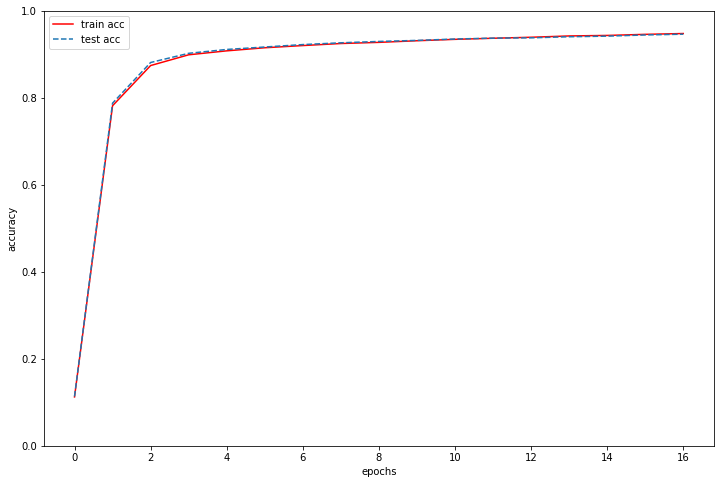

In [ ]:
# 훈련 데이터와 시험 데이터에 대한 정확도 추이 그래프 그리기
x = epochs

plt.figure(figsize=(12,8))
plt.plot(x, train_acc_list, color = "red", label = "train acc")
plt.plot(x, test_acc_list, linestyle = "--", label = "test acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

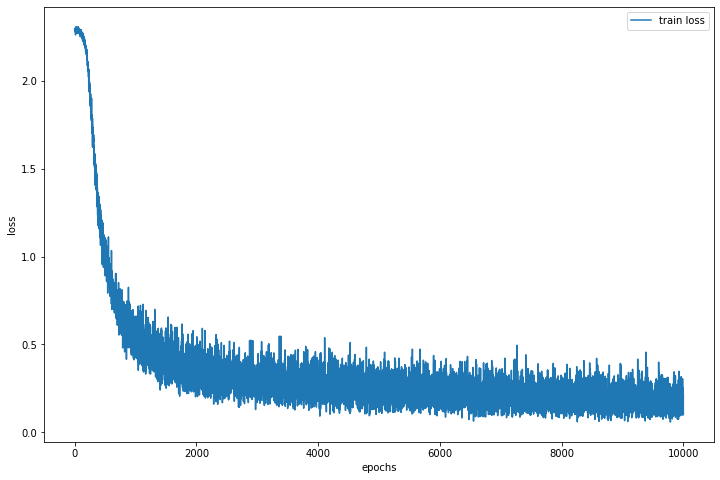

In [ ]:
# iter 당 훈련데이터 loss
x = np.arange(iters_num)

plt.figure(figsize=(12,8))
plt.plot(x, train_loss_list, label = "train loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()